In [1]:
# General

import pandas as pd
import numpy as np
from scipy import misc
import urllib.request, urllib.parse, urllib.error, io
from PIL import Image
from IPython.display import display, HTML, IFrame

# Static NBA API 

from nba_api.stats.static import teams # For team list
from nba_api.stats.static import players

# NBA API Endpoint

from nba_api.stats.endpoints import teamdashptpass# For team passing stats
from nba_api.stats.endpoints import playerdashptpass # For player passing stats
from nba_api.stats.endpoints import ShotChartDetail # For player shot location and frequency
from nba_api.stats.endpoints import commonplayerinfo # For Common Player Information

# Plotting Libraries

from matplotlib.patches import Circle, Rectangle, Arc
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

# Remove all Warnings
# import warnings
# warnings.filterwarnings('ignore')

# 1 Player Shot Type Overview

### 1.0 Inputs

In [2]:
player_id = input("Enter player ID: ")

Enter player ID: 1630224


In [3]:
team_id = input("Enter team ID: ")

Enter team ID: 1610612745


In [4]:
season_nullable = input("Enter Season that is to be analyzed: ")

Enter Season that is to be analyzed: 2021-22


#### 1.0.1 Verify Correct Player Information is Used

In [5]:
commonplayerinfo.CommonPlayerInfo(player_id=player_id).get_data_frames()[0]

,PERSON_ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,...,PLAYERCODE,FROM_YEAR,TO_YEAR,DLEAGUE_FLAG,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,GREATEST_75_FLAG
0,1630224,Jalen,Green,Jalen Green,"Green, Jalen",J. Green,jalen-green,2002-02-09T00:00:00,NBA G League Ignite,USA,...,jalen_green,2021,2022,Y,Y,Y,2021,1,2,N


#### 1.0.2 Verify Correct Team Information is Used

In [6]:
# Below returns a list of dictionaries, 1 for each NBA team
nba_teams=teams.get_teams()

# Let's create a Pandas DataFrame using extracted list of dictionaries
df_nba_teams=pd.DataFrame(nba_teams)

type(df_nba_teams)

# Print DataFrame
df_nba_teams[df_nba_teams['id'] == int(team_id)]

,id,full_name,abbreviation,nickname,city,state,year_founded
8,1610612745,Houston Rockets,HOU,Rockets,Houston,Texas,1967


In [7]:
# Create Dataframe of all of the player's attempted Shots during the specificed Regular Season

df_player_shots = ShotChartDetail(player_id=player_id,
                  team_id=team_id,
                  season_nullable= season_nullable,
                  season_type_all_star='Regular Season', 
                  context_measure_simple = 'FGA').get_data_frames()[0]

# Default for  is [context_measure_simple] is 'PTS' and will only return made shots, 
# but we want all shot attempts so we make it 'FGA'

In [8]:
# Inspect Column values for Shot Zone Area Column

ShotChartDetail(player_id=2544,
                team_id=1610612747,
                context_measure_simple = 'FGA').get_data_frames()[0].SHOT_ZONE_AREA.unique()

array(['Center(C)', 'Left Side Center(LC)', 'Right Side Center(RC)',
       'Left Side(L)', 'Right Side(R)', 'Back Court(BC)'], dtype=object)

In [9]:
# Inspect Column values for Shot Zone Area Basic

ShotChartDetail(player_id=2544,
                team_id=1610612747,
                context_measure_simple = 'FGA').get_data_frames()[0].SHOT_ZONE_BASIC.unique()

# Corner 3: The small area on the left and right side of the court near the baseline. The 3-point line is a few inches closer to the basket in the corners.
# In The Paint: These are shots taken inside the key, the rectangular box close to the basket that measures 15 feet out to the free throw line and 16 feet wide.
# Restricted Area: The four-foot area directly surrounding the basket, marked by a semicircle in the paint.
# Mid-range: Any shot that comes outside the paint but inside the 3-point line.
# Above the Break 3: Any 3-pointer that is not taken from the corners.
# Backcourt: Any shot taken from beyond half court, mostly at the end of quarters to beat the clock.
# Source: https://jr.nba.com/how-to-read-a-shot-chart/ 

array(['Restricted Area', 'In The Paint (Non-RA)', 'Above the Break 3',
       'Mid-Range', 'Left Corner 3', 'Right Corner 3', 'Backcourt'],
      dtype=object)

### 1.1 Calculating Shots Taken For Each Shot Zone

In [10]:
# Create Empty List to store Player Stats, this will be used to create Data Frame later
list_of_lists = []

#### 1.1.1. Total Shots Attempted

In [11]:
len (df_player_shots.index)

954

#### 1.1.2. Total Shots Missed or Made

In [12]:
df_player_shots['EVENT_TYPE'].value_counts()

Missed Shot    548
Made Shot      406
Name: EVENT_TYPE, dtype: int64

#### 1.1.3 Three Point Shots

In [13]:
# Three point shots Missed

missed_3pts= df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
                (df_player_shots['SHOT_TYPE'] == '3PT Field Goal')
                ].count()['GRID_TYPE']

In [14]:
# Three point shots Made

made_3pts = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
                (df_player_shots['SHOT_TYPE'] == '3PT Field Goal')
                ].count()['GRID_TYPE']

In [15]:
# Field Goal Percentage

percentage_3pts = made_3pts/(missed_3pts + made_3pts)

In [16]:
print(f"Total three point shots missed: {missed_3pts}")
print(f"Total three point shots made: {made_3pts}")
print(f"Three point shot field goal percentage: {round((100*percentage_3pts),2)}%")

Total three point shots missed: 301
Total three point shots made: 157
Three point shot field goal percentage: 34.28%


##### 1.1.3.1 Three point shots [Center Three Pointer]

In [17]:
#Missed Center Three Pointer

missed_center_3pts = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') &
                (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') & 
                (df_player_shots['SHOT_ZONE_BASIC'] == 'Above the Break 3') &
                (df_player_shots['SHOT_ZONE_AREA'] == 'Center(C)')
                ].count()['GRID_TYPE']

In [18]:
#Made Center Three Pointer

made_center_3pts= df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') &
                (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') & 
                (df_player_shots['SHOT_ZONE_BASIC'] == 'Above the Break 3') &
                (df_player_shots['SHOT_ZONE_AREA'] == 'Center(C)')
                ].count()['GRID_TYPE']

In [19]:
# Field Goal Percentage

percentage_center_3pts = made_center_3pts/(missed_center_3pts + made_center_3pts)

In [20]:
print(f"Total three point shots missed from above the break Center: {missed_center_3pts}")
print(f"Total three point shots made from above the break Center: {made_center_3pts}")
print(f"Center three point shot field goal percentage: {round((100*percentage_center_3pts),2)}%")

Total three point shots missed from above the break Center: 59
Total three point shots made from above the break Center: 37
Center three point shot field goal percentage: 38.54%


In [21]:
list_of_lists.append(['Above the Break 3','Center(C)',missed_center_3pts+made_center_3pts,made_center_3pts,percentage_center_3pts])

##### 1.1.3.2 Three point shots [Left Three Pointer]

In [22]:
#Missed Left Center Three Pointer

missed_left_3pts= df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') &
                    (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') & 
                    (df_player_shots['SHOT_ZONE_BASIC'] == 'Above the Break 3') &
                    (df_player_shots['SHOT_ZONE_AREA'] == 'Left Side Center(LC)')
                    ].count()['GRID_TYPE']

In [23]:
#Made Left Center Three Pointer

made_left_3pts= df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') &
                    (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') & 
                    (df_player_shots['SHOT_ZONE_BASIC'] == 'Above the Break 3') &
                    (df_player_shots['SHOT_ZONE_AREA'] == 'Left Side Center(LC)')
                    ].count()['GRID_TYPE']

In [24]:
# Field Goal Percentage

percentage_left_3pts = made_left_3pts/(missed_left_3pts + made_left_3pts)

In [25]:
print(f"Total three point shots missed from above the break Left Side: {missed_left_3pts}")
print(f"Total three point shots made from above the break Left Side: {made_left_3pts}")
print(f"Left Side three point shot field goal percentage: {round((100*percentage_left_3pts),2)}%")

Total three point shots missed from above the break Left Side: 103
Total three point shots made from above the break Left Side: 43
Left Side three point shot field goal percentage: 29.45%


In [26]:
list_of_lists.append(['Above the Break 3','Left Side Center(LC)',missed_left_3pts+made_left_3pts,\
                      made_left_3pts,percentage_left_3pts])

##### 1.1.3.3 Three point shots [Right Three Pointer]

In [27]:
#Missed Right Center Three Pointer

missed_right_3pts= df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') &
                    (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') & 
                    (df_player_shots['SHOT_ZONE_BASIC'] == 'Above the Break 3') &
                    (df_player_shots['SHOT_ZONE_AREA'] == 'Right Side Center(RC)')
                    ].count()['GRID_TYPE']

In [28]:
#Made Right Center Three Pointer

made_right_3pts= df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') &
                    (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') & 
                    (df_player_shots['SHOT_ZONE_BASIC'] == 'Above the Break 3') &
                    (df_player_shots['SHOT_ZONE_AREA'] == 'Right Side Center(RC)')
                    ].count()['GRID_TYPE']

In [29]:
# Field Goal Percentage

percentage_right_3pts = made_right_3pts/(missed_right_3pts + made_right_3pts)

In [30]:
print(f"Total three point shots missed from above the break Right Side: {missed_right_3pts}")
print(f"Total three point shots made from above the break Right Side: {made_right_3pts}")
print(f"Right Side three point shot field goal percentage: {round((100*percentage_right_3pts),2)}%")

Total three point shots missed from above the break Right Side: 91
Total three point shots made from above the break Right Side: 51
Right Side three point shot field goal percentage: 35.92%


In [31]:
list_of_lists.append(['Above the Break 3','Right Side Center(RC)',missed_right_3pts+made_right_3pts,\
                      made_right_3pts,percentage_right_3pts])

In [32]:
list_of_lists

[['Above the Break 3', 'Center(C)', 96, 37, 0.3854166666666667],
 ['Above the Break 3', 'Left Side Center(LC)', 146, 43, 0.2945205479452055],
 ['Above the Break 3', 'Right Side Center(RC)', 142, 51, 0.3591549295774648]]

##### 1.1.3.4 Three point shots [Left Corner 3]

In [33]:
# Missed Left Corner 3

missed_left_corner_3 = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') &
                        (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') &
                        (df_player_shots['SHOT_ZONE_BASIC'] == 'Left Corner 3')]\
                        .count()['GRID_TYPE']

In [34]:
# Made Left Corner 3

made_left_corner_3 = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') &
                        (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') &
                        (df_player_shots['SHOT_ZONE_BASIC'] == 'Left Corner 3')]\
                        .count()['GRID_TYPE']

In [35]:
# Field Goal Percentage

percentage_left_corner_3 = made_left_corner_3/(missed_left_corner_3 + made_left_corner_3)

In [36]:
print(f"Total left corner three point shots missed: {missed_left_corner_3}")
print(f"Total left corner three point shots made: {made_left_corner_3}")
print(f"Left Corner Three point shot field goal percentage: {round((100*percentage_left_corner_3),2)}%")

Total left corner three point shots missed: 31
Total left corner three point shots made: 17
Left Corner Three point shot field goal percentage: 35.42%


In [37]:
list_of_lists.append(['Left Corner 3','Left Side(L)',missed_left_corner_3+made_left_corner_3,\
                      made_left_corner_3,percentage_left_corner_3])

In [38]:
list_of_lists

[['Above the Break 3', 'Center(C)', 96, 37, 0.3854166666666667],
 ['Above the Break 3', 'Left Side Center(LC)', 146, 43, 0.2945205479452055],
 ['Above the Break 3', 'Right Side Center(RC)', 142, 51, 0.3591549295774648],
 ['Left Corner 3', 'Left Side(L)', 48, 17, 0.3541666666666667]]

##### 1.1.3.5 Three point shots [Right Corner 3]

In [39]:
# Missed Right Corner 3

missed_right_corner_3 = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') &
                        (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') &
                        (df_player_shots['SHOT_ZONE_BASIC'] == 'Right Corner 3')]\
                        .count()['GRID_TYPE']

In [40]:
# Made Right Corner 3

made_right_corner_3 = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') &
                        (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') &
                        (df_player_shots['SHOT_ZONE_BASIC'] == 'Right Corner 3')]\
                        .count()['GRID_TYPE']

In [41]:
# Field Goal Percentage

percentage_right_corner_3 = made_right_corner_3/(missed_right_corner_3 + made_right_corner_3)

In [42]:
print(f"Total right corner three point shots missed: {missed_right_corner_3}")
print(f"Total right corner three point shots made: {made_right_corner_3}")
print(f"RightCorner Three point shot field goal percentage: {round((100*percentage_right_corner_3),2)}%")

Total right corner three point shots missed: 15
Total right corner three point shots made: 9
RightCorner Three point shot field goal percentage: 37.5%


In [43]:
list_of_lists.append(['Right Corner 3','Right Side(R)',missed_right_corner_3+made_right_corner_3,\
                      made_right_corner_3,percentage_right_corner_3])

In [44]:
list_of_lists

[['Above the Break 3', 'Center(C)', 96, 37, 0.3854166666666667],
 ['Above the Break 3', 'Left Side Center(LC)', 146, 43, 0.2945205479452055],
 ['Above the Break 3', 'Right Side Center(RC)', 142, 51, 0.3591549295774648],
 ['Left Corner 3', 'Left Side(L)', 48, 17, 0.3541666666666667],
 ['Right Corner 3', 'Right Side(R)', 24, 9, 0.375]]

##### 1.1.3.6 Three point shots [Backcourt]

In [45]:
# Missed Backcourt Shots

missed_backcourt = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
                (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') & 
                (df_player_shots['SHOT_ZONE_BASIC'] == 'Backcourt')].count()['GRID_TYPE']

In [46]:
# Made Backcourt Shots

made_backcourt = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
                (df_player_shots['SHOT_TYPE'] == '3PT Field Goal') & 
                (df_player_shots['SHOT_ZONE_BASIC'] == 'Backcourt')].count()['GRID_TYPE']

In [47]:
# Field Goal Percentage

percentage_backcourt = made_backcourt/(missed_backcourt + made_backcourt)

In [48]:
print(f"Total backcourt three point shots missed: {missed_backcourt}")
print(f"Total backcourt three point shots made: {made_backcourt}")
print(f"Backcourt Three point shot field goal percentage: {round((100*percentage_backcourt),2)}%")

Total backcourt three point shots missed: 1
Total backcourt three point shots made: 0
Backcourt Three point shot field goal percentage: 0.0%


In [49]:
list_of_lists.append(['Backcourt','Back Court(BC)',missed_backcourt+made_backcourt,\
                      made_backcourt,percentage_backcourt])

In [50]:
list_of_lists

[['Above the Break 3', 'Center(C)', 96, 37, 0.3854166666666667],
 ['Above the Break 3', 'Left Side Center(LC)', 146, 43, 0.2945205479452055],
 ['Above the Break 3', 'Right Side Center(RC)', 142, 51, 0.3591549295774648],
 ['Left Corner 3', 'Left Side(L)', 48, 17, 0.3541666666666667],
 ['Right Corner 3', 'Right Side(R)', 24, 9, 0.375],
 ['Backcourt', 'Back Court(BC)', 1, 0, 0.0]]

#### 1.1.4 Two point shots

In [51]:
df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
                (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')].count()['GRID_TYPE']

247

##### 1.1.4.1 Two Point Shots

In [52]:
# Two point shots Missed

missed_2pts= df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
                (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')
                ].count()['GRID_TYPE']

In [53]:
# Two point shots Made

made_2pts = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
                (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')
                ].count()['GRID_TYPE']

In [54]:
# Field Goal Percentage

percentage_2pts = made_2pts/(missed_2pts + made_2pts)

In [55]:
print(f"Total two point shots missed: {missed_2pts}")
print(f"Total two point shots made: {made_2pts}")
print(f"Two point shot field goal percentage: {round((100*percentage_2pts),2)}%")

Total two point shots missed: 247
Total two point shots made: 249
Two point shot field goal percentage: 50.2%


##### 1.1.4.2 Two point shots [Restricted Area]

In [56]:
# Missed Restricted Area Two Pointers

missed_RA_2pts = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
                (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
                (df_player_shots['SHOT_ZONE_BASIC'] == 'Restricted Area')].count()['GRID_TYPE']

In [57]:
# Made Restricted Area Two Pointers

made_RA_2pts = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
                (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
                (df_player_shots['SHOT_ZONE_BASIC'] == 'Restricted Area')].count()['GRID_TYPE']

In [58]:
# Field Goal Percentage

percentage_RA_2pts = made_RA_2pts/(missed_RA_2pts + made_RA_2pts)

In [59]:
print(f"Total two point shots missed: {missed_RA_2pts}")
print(f"Total two point shots made: {made_RA_2pts}")
print(f"Two point shot field goal percentage: {round((100*percentage_RA_2pts),2)}%")

Total two point shots missed: 118
Total two point shots made: 193
Two point shot field goal percentage: 62.06%


In [60]:
list_of_lists.append(['Restricted Area','Center(C)',missed_RA_2pts+made_RA_2pts,\
                      made_RA_2pts,percentage_RA_2pts])

In [61]:
list_of_lists

[['Above the Break 3', 'Center(C)', 96, 37, 0.3854166666666667],
 ['Above the Break 3', 'Left Side Center(LC)', 146, 43, 0.2945205479452055],
 ['Above the Break 3', 'Right Side Center(RC)', 142, 51, 0.3591549295774648],
 ['Left Corner 3', 'Left Side(L)', 48, 17, 0.3541666666666667],
 ['Right Corner 3', 'Right Side(R)', 24, 9, 0.375],
 ['Backcourt', 'Back Court(BC)', 1, 0, 0.0],
 ['Restricted Area', 'Center(C)', 311, 193, 0.6205787781350482]]

##### 1.1.4.3 Two point shots [Center Paint (Not Restricted Area and neither Left or Right strips of Paint Area)] 

In [62]:
# Missed Restricted Area Two Pointers

missed_center_paint_2pts = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
                (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
                (df_player_shots['SHOT_ZONE_BASIC'] == 'In The Paint (Non-RA)') &
                (df_player_shots['SHOT_ZONE_AREA'] == 'Center(C)') ].count()['GRID_TYPE']

In [63]:
# Made Restricted Area Two Pointers

made_center_paint_2pts = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
                (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
                (df_player_shots['SHOT_ZONE_BASIC'] == 'In The Paint (Non-RA)') &
                (df_player_shots['SHOT_ZONE_AREA'] == 'Center(C)') ].count()['GRID_TYPE']

In [64]:
# Field Goal Percentage

percentage_center_paint_2pts = made_center_paint_2pts/(missed_center_paint_2pts + made_center_paint_2pts)

In [65]:
print(f"Total two point shots missed: {missed_center_paint_2pts}")
print(f"Total two point shots made: {made_center_paint_2pts}")
print(f"Two point shot field goal percentage: {round((100*percentage_center_paint_2pts),2)}%")

Total two point shots missed: 64
Total two point shots made: 14
Two point shot field goal percentage: 17.95%


In [66]:
list_of_lists.append(['In The Paint (Non-RA)','Center(C)',missed_center_paint_2pts+made_center_paint_2pts,\
                      made_center_paint_2pts,percentage_center_paint_2pts])

In [67]:
list_of_lists

[['Above the Break 3', 'Center(C)', 96, 37, 0.3854166666666667],
 ['Above the Break 3', 'Left Side Center(LC)', 146, 43, 0.2945205479452055],
 ['Above the Break 3', 'Right Side Center(RC)', 142, 51, 0.3591549295774648],
 ['Left Corner 3', 'Left Side(L)', 48, 17, 0.3541666666666667],
 ['Right Corner 3', 'Right Side(R)', 24, 9, 0.375],
 ['Backcourt', 'Back Court(BC)', 1, 0, 0.0],
 ['Restricted Area', 'Center(C)', 311, 193, 0.6205787781350482],
 ['In The Paint (Non-RA)', 'Center(C)', 78, 14, 0.1794871794871795]]

##### 1.1.4.4 Two point shots [Mid Range (Center Only)] 

In [68]:
# Missed Midrange Center Two Pointers

missed_center_midrange_2pts = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
                (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
                (df_player_shots['SHOT_ZONE_BASIC'] == 'Mid-Range') &
                (df_player_shots['SHOT_ZONE_AREA'] == 'Center(C)') ].count()['GRID_TYPE']

In [69]:
# Made Midrange Center Two Pointers

made_center_midrange_2pts = df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
                (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
                (df_player_shots['SHOT_ZONE_BASIC'] == 'Mid-Range') &
                (df_player_shots['SHOT_ZONE_AREA'] == 'Center(C)') ].count()['GRID_TYPE']

In [70]:
# Field Goal Percentage

percentage_center_midrange_2pts = made_center_midrange_2pts/(missed_center_midrange_2pts + made_center_midrange_2pts)

In [71]:
list_of_lists.append(['Mid-Range','Center(C)',(missed_center_midrange_2pts + made_center_midrange_2pts),\
                      made_center_midrange_2pts,percentage_center_midrange_2pts])

In [72]:
list_of_lists

[['Above the Break 3', 'Center(C)', 96, 37, 0.3854166666666667],
 ['Above the Break 3', 'Left Side Center(LC)', 146, 43, 0.2945205479452055],
 ['Above the Break 3', 'Right Side Center(RC)', 142, 51, 0.3591549295774648],
 ['Left Corner 3', 'Left Side(L)', 48, 17, 0.3541666666666667],
 ['Right Corner 3', 'Right Side(R)', 24, 9, 0.375],
 ['Backcourt', 'Back Court(BC)', 1, 0, 0.0],
 ['Restricted Area', 'Center(C)', 311, 193, 0.6205787781350482],
 ['In The Paint (Non-RA)', 'Center(C)', 78, 14, 0.1794871794871795],
 ['Mid-Range', 'Center(C)', 35, 12, 0.34285714285714286]]

##### 1.1.4.5 Two point shots [Mid Range (All Left Side and Left Center and Left Paint Shots)] 

In [73]:
# Missed Midrange Left Sided Two Pointers

a = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'Mid-Range') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Left Side(L)') ].count()['GRID_TYPE'])
    # Left Side Midrange Shots

b = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'Mid-Range') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Left Side Center(LC)') ].count()['GRID_TYPE'])
    # Left Side Midrange Center Shots

c = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'In The Paint (Non-RA)') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Left Side(L)') ].count()['GRID_TYPE'])
    # Left Midrange Paint Strip Shots
    
missed_left_midrange_2pts = a + b + c

In [74]:
# Made Midrange Left Sided Two Pointers

a = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'Mid-Range') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Left Side(L)') ].count()['GRID_TYPE'])
    # Left Side Midrange Shots

b = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'Mid-Range') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Left Side Center(LC)') ].count()['GRID_TYPE'])
    # Left Side Midrange Center Shots

c = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'In The Paint (Non-RA)') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Left Side(L)') ].count()['GRID_TYPE'])
    # Left Midrange Paint Strip Shots
    
made_left_midrange_2pts = a + b + c

In [75]:
# Field Goal Percentage

percentage_left_midrange_2pts = made_left_midrange_2pts/(missed_left_midrange_2pts + made_left_midrange_2pts)

In [76]:
list_of_lists.append(['Mid-Range','Left Side(L)',(missed_left_midrange_2pts + made_left_midrange_2pts),\
                      made_left_midrange_2pts,percentage_left_midrange_2pts])

In [77]:
list_of_lists

[['Above the Break 3', 'Center(C)', 96, 37, 0.3854166666666667],
 ['Above the Break 3', 'Left Side Center(LC)', 146, 43, 0.2945205479452055],
 ['Above the Break 3', 'Right Side Center(RC)', 142, 51, 0.3591549295774648],
 ['Left Corner 3', 'Left Side(L)', 48, 17, 0.3541666666666667],
 ['Right Corner 3', 'Right Side(R)', 24, 9, 0.375],
 ['Backcourt', 'Back Court(BC)', 1, 0, 0.0],
 ['Restricted Area', 'Center(C)', 311, 193, 0.6205787781350482],
 ['In The Paint (Non-RA)', 'Center(C)', 78, 14, 0.1794871794871795],
 ['Mid-Range', 'Center(C)', 35, 12, 0.34285714285714286],
 ['Mid-Range', 'Left Side(L)', 26, 11, 0.4230769230769231]]

##### 1.1.4.6 Two point shots [Mid Range (All Right Side and Right Center and Right Paint Shots)] 

In [78]:
# Missed Midrange Right Sided Shots

d = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'Mid-Range') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Right Side(R)') ].count()['GRID_TYPE'])
    # Right Side Midrange Shots

e = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'Mid-Range') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Right Side Center(RC)') ].count()['GRID_TYPE'])
    # Right Side Midrange Center Shots

f = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Missed Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'In The Paint (Non-RA)') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Right Side(R)') ].count()['GRID_TYPE'])
    # Right Midrange Paint Strip Shots
    
missed_right_midrange_2pts = d + e + f

In [79]:
# Made Midrange Right Sided Shots

d = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'Mid-Range') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Right Side(R)') ].count()['GRID_TYPE'])
    # Right Side Midrange Shots

e = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'Mid-Range') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Right Side Center(RC)') ].count()['GRID_TYPE'])
    # Right Side Midrange Center Shots

f = (df_player_shots[(df_player_shots['EVENT_TYPE'] == 'Made Shot') & 
    (df_player_shots['SHOT_TYPE'] == '2PT Field Goal')& 
    (df_player_shots['SHOT_ZONE_BASIC'] == 'In The Paint (Non-RA)') &
    (df_player_shots['SHOT_ZONE_AREA'] == 'Right Side(R)') ].count()['GRID_TYPE'])
    # Right Midrange Paint Strip Shots
    
made_right_midrange_2pts = d + e + f

In [80]:
# Field Goal Percentage

percentage_right_midrange_2pts = made_right_midrange_2pts/(missed_right_midrange_2pts + made_right_midrange_2pts)

In [81]:
list_of_lists.append(['Mid-Range','Right Side(R)',(missed_right_midrange_2pts + made_right_midrange_2pts),\
                      made_right_midrange_2pts,percentage_right_midrange_2pts])

In [82]:
list_of_lists

[['Above the Break 3', 'Center(C)', 96, 37, 0.3854166666666667],
 ['Above the Break 3', 'Left Side Center(LC)', 146, 43, 0.2945205479452055],
 ['Above the Break 3', 'Right Side Center(RC)', 142, 51, 0.3591549295774648],
 ['Left Corner 3', 'Left Side(L)', 48, 17, 0.3541666666666667],
 ['Right Corner 3', 'Right Side(R)', 24, 9, 0.375],
 ['Backcourt', 'Back Court(BC)', 1, 0, 0.0],
 ['Restricted Area', 'Center(C)', 311, 193, 0.6205787781350482],
 ['In The Paint (Non-RA)', 'Center(C)', 78, 14, 0.1794871794871795],
 ['Mid-Range', 'Center(C)', 35, 12, 0.34285714285714286],
 ['Mid-Range', 'Left Side(L)', 26, 11, 0.4230769230769231],
 ['Mid-Range', 'Right Side(R)', 46, 19, 0.41304347826086957]]

### 1.2 League Average Table Updated

In [83]:
# Convert List of Lists to a Panda Data Frame
player_df = pd.DataFrame(list_of_lists, columns=['SHOT_ZONE_BASIC','SHOT_ZONE_AREA','PLAYER_FGA',\
                                                 'PLAYER_FGM', 'FG_PLAYER_PCT'])

In [84]:
# Inspect Data Frame
player_df

,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,PLAYER_FGA,PLAYER_FGM,FG_PLAYER_PCT
0,Above the Break 3,Center(C),96,37,0.385417
1,Above the Break 3,Left Side Center(LC),146,43,0.294521
2,Above the Break 3,Right Side Center(RC),142,51,0.359155
3,Left Corner 3,Left Side(L),48,17,0.354167
4,Right Corner 3,Right Side(R),24,9,0.375000
5,Backcourt,Back Court(BC),1,0,0.000000
6,Restricted Area,Center(C),311,193,0.620579
7,In The Paint (Non-RA),Center(C),78,14,0.179487
8,Mid-Range,Center(C),35,12,0.342857
9,Mid-Range,Left Side(L),26,11,0.423077


In [85]:
# Generate League Average for the Season in Question

df_league_average = ShotChartDetail(
    season_nullable= season_nullable, # Utilizes Same Season as the Player
    player_id = player_id, # Utilizes Player ID although this does not affect the list position we are extracting [1]
    team_id=team_id, # Same Team ID as player but does does not affect the list position we are extracting here [1]
    context_measure_simple="FGA" # Explained Before
).get_data_frames()[1]

In [86]:
# Refine League DataFrame to be Similar to Player Data Frame
# Drop Disimilar columns

df_league_average_refined = df_league_average.drop(columns=['SHOT_ZONE_RANGE','GRID_TYPE','FG_PCT'])

In [87]:
df_league_average_refined.head()

,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,FGA,FGM
0,Above the Break 3,Back Court(BC),35,4
1,Above the Break 3,Center(C),16368,5613
2,Above the Break 3,Left Side Center(LC),24924,8511
3,Above the Break 3,Right Side Center(RC),23120,8171
4,Backcourt,Back Court(BC),440,11


In [88]:
# Rename the fields 
# Row 1: Re-classified above the break 3 shots from the backcourt as Backcourt shots
# Rows 7 and 8: Originally classified as in the paint, but can be re-classified as midrange shots
# from either left or right side
# Rows 12 and 15: Left/Right Side Center classified as just Right and Left to simplify things

df_league_average_refined.loc[0:0,'SHOT_ZONE_BASIC'] = 'Backcourt' # Change [Above the Break 3] to [Backcourt]
df_league_average_refined.loc[7:7,'SHOT_ZONE_BASIC'] = 'Mid-Range' # Change [In The Paint (Non-RA)] to [Mid-Range]
df_league_average_refined.loc[8:8,'SHOT_ZONE_BASIC'] = 'Mid-Range' # Change [In The Paint (Non-RA)] to [Mid-Range]
df_league_average_refined.loc[12:12,'SHOT_ZONE_AREA'] = 'Left Side(L)' # Change [In The Paint (Non-RA)] to [Mid-Range]
df_league_average_refined.loc[15:15,'SHOT_ZONE_AREA'] = 'Right Side(R)' # Change [In The Paint (Non-RA)] to [Mid-Range]

In [89]:
df_league_average_refined

,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,FGA,FGM
0,Backcourt,Back Court(BC),35,4
1,Above the Break 3,Center(C),16368,5613
2,Above the Break 3,Left Side Center(LC),24924,8511
3,Above the Break 3,Right Side Center(RC),23120,8171
4,Backcourt,Back Court(BC),440,11
5,In The Paint (Non-RA),Center(C),23351,9813
6,In The Paint (Non-RA),Center(C),11777,5228
7,Mid-Range,Left Side(L),2197,949
8,Mid-Range,Right Side(R),2343,1000
9,Left Corner 3,Left Side(L),11377,4371


In [90]:
# Aggregate and Sum over similar SHOT_ZONE_BASIC and SHOT_ZONE_AREA values

df_league_average_refined = df_league_average_refined.groupby(['SHOT_ZONE_BASIC','SHOT_ZONE_AREA'])\
                             .agg({'FGA': [sum],'FGM': [sum]})

In [91]:
df_league_average_refined

FGA    FGM
                                               sum    sum
SHOT_ZONE_BASIC       SHOT_ZONE_AREA                     
Above the Break 3     Center(C)              16368   5613
                      Left Side Center(LC)   24924   8511
                      Right Side Center(RC)  23120   8171
Backcourt             Back Court(BC)           475     15
In The Paint (Non-RA) Center(C)              35128  15041
Left Corner 3         Left Side(L)           11377   4371
Mid-Range             Center(C)               6253   2664
                      Left Side(L)           12863   5217
                      Right Side(R)          13136   5332
Restricted Area       Center(C)              62987  41140
Right Corner 3        Right Side(R)          10091   3855

In [92]:
# Aggregate Creates an array for column title, so we reset index to eliminate the extra column title

df_league_average_refined = df_league_average_refined.droplevel(axis=1, level=1).reset_index()

In [93]:
df_league_average_refined

,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,FGA,FGM
0,Above the Break 3,Center(C),16368,5613
1,Above the Break 3,Left Side Center(LC),24924,8511
2,Above the Break 3,Right Side Center(RC),23120,8171
3,Backcourt,Back Court(BC),475,15
4,In The Paint (Non-RA),Center(C),35128,15041
5,Left Corner 3,Left Side(L),11377,4371
6,Mid-Range,Center(C),6253,2664
7,Mid-Range,Left Side(L),12863,5217
8,Mid-Range,Right Side(R),13136,5332
9,Restricted Area,Center(C),62987,41140


In [94]:
# Add FG_PCT Column

df_league_average_refined['FG_PCT'] = df_league_average_refined['FGM']/df_league_average_refined['FGA']

In [95]:
df_league_average_refined.head()

,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,FGA,FGM,FG_PCT
0,Above the Break 3,Center(C),16368,5613,0.342925
1,Above the Break 3,Left Side Center(LC),24924,8511,0.341478
2,Above the Break 3,Right Side Center(RC),23120,8171,0.353417
3,Backcourt,Back Court(BC),475,15,0.031579
4,In The Paint (Non-RA),Center(C),35128,15041,0.428177


In [96]:
pd.merge(df_league_average_refined, player_df, on=['SHOT_ZONE_BASIC','SHOT_ZONE_AREA'], how='outer')

,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,FGA,FGM,FG_PCT,PLAYER_FGA,PLAYER_FGM,FG_PLAYER_PCT
0,Above the Break 3,Center(C),16368,5613,0.342925,96,37,0.385417
1,Above the Break 3,Left Side Center(LC),24924,8511,0.341478,146,43,0.294521
2,Above the Break 3,Right Side Center(RC),23120,8171,0.353417,142,51,0.359155
3,Backcourt,Back Court(BC),475,15,0.031579,1,0,0.000000
4,In The Paint (Non-RA),Center(C),35128,15041,0.428177,78,14,0.179487
5,Left Corner 3,Left Side(L),11377,4371,0.384196,48,17,0.354167
6,Mid-Range,Center(C),6253,2664,0.426036,35,12,0.342857
7,Mid-Range,Left Side(L),12863,5217,0.405582,26,11,0.423077
8,Mid-Range,Right Side(R),13136,5332,0.405907,46,19,0.413043
9,Restricted Area,Center(C),62987,41140,0.653151,311,193,0.620579


# 2.0 Plotting Shot Chart
credit: https://danielwelch.github.io/nba-team-shot-charts.html

In [97]:
def court(ax=None, color='black', lw=2, outer_lines=False,direction='up',short_three=False):
    '''
    Plots an NBA court
    outer_lines - accepts False or True. Plots the outer side lines of the court.
    direction - 'up' or 'down' depending on how you like to view the court
    Original function from http://savvastjortjoglou.com/
    '''
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        if direction=='up':
            ax = plt.gca(xlim = [-30,30],ylim = [43,-7],xticks=[],yticks=[],aspect=1.0)
            plt.text(22,44,'By: Doingthedishes',color='black',horizontalalignment='center',fontsize=20,fontweight='bold')
        elif direction=='down':
            ax = plt.gca(xlim = [30,-30],ylim = [-7,43],xticks=[],yticks=[],aspect=1.0)
            plt.text(-22,-7,'By: Doingthedishes',color='black',horizontalalignment='center',fontsize=20,fontweight='bold')
        else:
            ax = plt.gca()
    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 1.5 
    hoop = Circle((0, 0), radius=0.75, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-3, -0.75), 6, -0.1, linewidth=lw, color=color)

    # The paint
    # Create the outer box of the paint, width=16ft, height=19ft
    outer_box = Rectangle((-8, -5.25), 16, 19, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-6, -5.25), 12, 19, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 13.75), 12, 12, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 13.75), 12, 12, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 8, 8, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    if not short_three:
        corner_three_a = Rectangle((-22, -5.25), 0, np.sqrt(23.75**2-22.0**2)+5.25, linewidth=lw,
                                   color=color)
        corner_three_b = Rectangle((22, -5.25), 0, np.sqrt(23.75**2-22.0**2)+5.25, linewidth=lw, color=color)
        # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
        three_arc = Arc((0, 0), 47.5, 47.5, theta1=np.arccos(22/23.75)*180/np.pi, theta2=180.0-np.arccos(22/23.75)*180/np.pi, linewidth=lw,
                        color=color)
    else:
        corner_three_a = Rectangle((-22, -5.25), 0, 5.25, linewidth=lw,
                           color=color)
        corner_three_b = Rectangle((22, -5.25), 0, 5.25, linewidth=lw, color=color)
        # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
        three_arc = Arc((0, 0), 44.0, 44.0, theta1=0, theta2=180, linewidth=lw,
                        color=color)
        # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc]  

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-25, -5.25), 50, 46.75, linewidth=lw,
                                color=color, fill=False)
        center_outer_arc = Arc((0, 41.25), 12, 12, theta1=180, theta2=0,
                                linewidth=lw, color=color)
        center_inner_arc = Arc((0, 41.25), 4, 4, theta1=180, theta2=0,
                                linewidth=lw, color=color)
        court_elements = court_elements + [outer_lines,center_outer_arc,center_inner_arc]
    else:
        ax.plot([-25,25],[-5.25,-5.25],linewidth=lw,color=color)
    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)
#    ax.axis('off')
    return ax

def zones(**kwargs):
    '''
    Plots zones on the court as per NBA.com
    the plot adds to the last plot used or starts a new figure
    '''
    ax = plt.gca()
    zone1 = Arc((0, 0), 16.0, 16.0,theta1 = -41.0,theta2 = 180.0+41.0,**kwargs)
    zone2 = Arc((0, 0), 32.0, 32.0,theta1 = -19.2,theta2 = 180.0+19.2, **kwargs)
    ax.add_patch(zone1)
    ax.add_patch(zone2)
    ang = 60.0
    ax.plot([np.cos(ang/180*np.pi)*8, np.cos(ang/180*np.pi)*16],
             [np.sin(ang/180*np.pi)*8, np.sin(ang/180*np.pi)*16],**kwargs)
    ang = 120.0
    ax.plot([np.cos(ang/180*np.pi)*8, np.cos(ang/180*np.pi)*16],
             [np.sin(ang/180*np.pi)*8, np.sin(ang/180*np.pi)*16],**kwargs)
    ax.plot([22,25],[14-5.25,14-5.25],**kwargs)
    ax.plot([-22,-25],[14-5.25,14-5.25],**kwargs)
    ang = 36.0
    ax.plot([np.cos(ang/180*np.pi)*16, np.cos(ang/180*np.pi)*23.75],
             [np.sin(ang/180*np.pi)*16, np.sin(ang/180*np.pi)*23.75],**kwargs)
    ang = 72.0
    ax.plot([np.cos(ang/180*np.pi)*16, np.cos(ang/180*np.pi)*24],
             [np.sin(ang/180*np.pi)*16, np.sin(ang/180*np.pi)*24],**kwargs)
    ang = 72.0+36.0
    ax.plot([np.cos(ang/180*np.pi)*16, np.cos(ang/180*np.pi)*24],
             [np.sin(ang/180*np.pi)*16, np.sin(ang/180*np.pi)*24],**kwargs)
    ang = 72.0*2
    ax.plot([np.cos(ang/180*np.pi)*16, np.cos(ang/180*np.pi)*23.75],
             [np.sin(ang/180*np.pi)*16, np.sin(ang/180*np.pi)*23.75],**kwargs)
    ang = 72.0
    ax.plot([np.cos(ang/180*np.pi)*24, np.cos(ang/180*np.pi)*41.25],
             [np.sin(ang/180*np.pi)*24, 41.25],**kwargs)
    ang = 72.0+36.0
    ax.plot([np.cos(ang/180*np.pi)*24, np.cos(ang/180*np.pi)*41.25],
             [np.sin(ang/180*np.pi)*24, 41.25],**kwargs)
        
def text_in_zone(string,zone,box_alpha = 0.75,**kwargs):
    '''
    Adds text to zones. 
    Input: 
    string - text to be added
    zone - specify zone (tuple)
    Options:
    box_alpha - string box transparency 
    '''
    if zone == ('Less Than 8 ft.','Center(C)') :
        t = plt.text(0,2,string,horizontalalignment='center',verticalalignment='center',**kwargs)
        t.set_bbox(dict(color='white', alpha=box_alpha))
    elif zone[0] ==  '8-16 ft.':
        if zone[1] == 'Center(C)':
            t = plt.text(0,12,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
        elif zone[1] == 'Right Side(R)' :
            t = plt.text(12,0,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
        elif zone[1] == 'Left Side(L)':
            t = plt.text(-12,0,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
    elif zone[0] == '16-24 ft.':
        if zone[1] == 'Center(C)':
            t = plt.text(0,20,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
        elif zone[1] == 'Right Side(R)':
            t = plt.text(18,7.3,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
        elif zone[1] ==  'Left Side(L)':
            t = plt.text(-18,7.3,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
        elif zone[1] == 'Right Side Center(RC)':
            t = plt.text(12,15.5,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
        elif zone[1] == 'Left Side Center(LC)':
            t = plt.text(-12,15.5,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
    elif zone[0] == '24+ ft.':
        if zone[1] == 'Center(C)':
            t = plt.text(0,28,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
        elif zone[1] == 'Right Side(R)':
            t = plt.text(27,0,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
        elif zone[1] == 'Left Side(L)':
            t = plt.text(-27,0,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
        elif zone[1] == 'Right Side Center(RC)':
            t = plt.text(19,24,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))
        elif zone[1] == 'Left Side Center(LC)':
            t = plt.text(-19,24,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha)) 
    if zone == ('Back Court Shot', 'Back Court(BC)') :
            t = plt.text(0,39,string,horizontalalignment='center',verticalalignment='center',**kwargs)
            t.set_bbox(dict(color='white', alpha=box_alpha))


def players_picture(player_id):
    url = "https://cdn.nba.com/headshots/nba/latest/1040x760/"
    player_id= str(player_id)
    ext = ".png"
    full_url = url+player_id+ext
    pic = urllib.request.urlretrieve(full_url)
    return (plt.imread(pic[0]))
    
def shot_zone(X,Y):
    '''
    Uses shot coordinates x and y (in feet - divide by 10 if using the shotchart units)
    and returns a tuple with the zone location
    '''
    r = np.sqrt(X**2+Y**2) # Create radius from X,Y location of shot
    a = np.arctan2(Y,X)*180.0/np.pi # Determines from X,Y if the shot if right side or left side or center
    if (Y<0) & (X > 0):
        a = 0
    elif (Y<0) & (X < 0):
        a = 180
    if r<=8:
        z = ('Less Than 8 ft.','Center(C)')
    elif (r>8) & (r<=16):
        if a < 60:
            z = ('8-16 ft.','Right Side(R)')
        elif (a>=60) & (a<=120):
            z = ('8-16 ft.','Center(C)')
        else:
            z = ('8-16 ft.','Left Side(L)')
    elif (r>16) & (r<=23.75):
        if a < 36:
            z = ('16-24 ft.','Right Side(R)')
        elif (a>=36) & (a<72):
            z = ('16-24 ft.','Right Side Center(RC)')
        elif (a>=72) & (a<=108):
            z = ('16-24 ft.','Center(C)')
        elif (a>108) & (a<144):
            z = ('16-24 ft.','Left Side Center(LC)')
        else:
            z = ('16-24 ft.','Left Side(L)')
    elif r>23.75:
        if a < 72:
            z = ('24+ ft.','Right Side Center(RC)')
        elif (a>=72) & (a<=108):
            z = ('24+ ft.','Center(C)')
        else:
            z = ('24+ ft.','Left Side Center(LC)')
    if (np.abs(X)>=22):
        if (X > 0) & (np.abs(Y)<8.75):
            z = ('24+ ft.','Right Side(R)')
        elif (X < 0) & (np.abs(Y)<8.75):
            z = ('24+ ft.','Left Side(L)')
        elif (X > 0) & (np.abs(Y)>=8.75):
            z = ('24+ ft.','Right Side Center(RC)')
        elif (X < 0) & (np.abs(Y)>=8.75):
            z = ('24+ ft.','Left Side Center(LC)')
    if Y >= 40:
        z = ('Back Court Shot', 'Back Court(BC)')
    return z

def shot_zone_short_three(X,Y):
    '''
    Uses shot coordinates x and y (in feet - divide by 10 if using the shotchart units)
    and returns a tuple with the zone location
    '''
    r = np.sqrt(X**2+Y**2) # Create radius from X,Y location of shot
    a = np.arctan2(Y,X)*180.0/np.pi # Determines from X,Y if the shot if right side or left side or center
    if (Y<0) & (X > 0):
        a = 0
    elif (Y<0) & (X < 0):
        a = 180
    if r<=8:
        z = ('Less Than 8 ft.','Center(C)')
    elif (r>8) & (r<=16):
        if a < 60:
            z = ('8-16 ft.','Right Side(R)')
        elif (a>=60) & (a<=120):
            z = ('8-16 ft.','Center(C)')
        else:
            z = ('8-16 ft.','Left Side(L)')
    elif (r>16) & (r<=22.0):
        if a < 36:
            z = ('16-24 ft.','Right Side(R)')
        elif (a>=36) & (a<72):
            z = ('16-24 ft.','Right Side Center(RC)')
        elif (a>=72) & (a<=108):
            z = ('16-24 ft.','Center(C)')
        elif (a>108) & (a<144):
            z = ('16-24 ft.','Left Side Center(LC)')
        else:
            z = ('16-24 ft.','Left Side(L)')
    elif r>22.0:
        if a < 72:
            z = ('24+ ft.','Right Side Center(RC)')
        elif (a>=72) & (a<=108):
            z = ('24+ ft.','Center(C)')
        else:
            z = ('24+ ft.','Left Side Center(LC)')
    if (np.abs(X)>=22):
        if (X > 0) & (np.abs(Y)<8.75):
            z = ('24+ ft.','Right Side(R)')
        elif (X < 0) & (np.abs(Y)<8.75):
            z = ('24+ ft.','Left Side(L)')
        elif (X > 0) & (np.abs(Y)>=8.75):
            z = ('24+ ft.','Right Side Center(RC)')
        elif (X < 0) & (np.abs(Y)>=8.75):
            z = ('24+ ft.','Left Side Center(LC)')
    if Y >= 40:
        z = ('Back Court Shot', 'Back Court(BC)')
    return z

def shot_heatmap(df,sigma = 1,log=False,player_pic=True,ax=None,cmap='jet'):
    '''
    This function plots a heatmap based on the shot chart.
    input - dataframe with x and y coordinates.
    optional - log (default false) plots heatmap in log scale. 
               player (default true) adds player's picture and name if true 
               sigma - the sigma of the Gaussian kernel. In feet (default=1)
    '''
    n,_,_ = np.histogram2d( 0.1*df['LOC_X'].values, 0.1*df['LOC_Y'].values,bins = [500, 500],range = [[-25,25],[-5.25,44.75]])
    KDE = ndimage.filters.gaussian_filter(n,10.0*sigma)
    N = 1.0*KDE/np.sum(KDE)
    if ax is None:
        ax = plt.gca(xlim = [30,-30],ylim = [-7,43],xticks=[],yticks=[],aspect=1.0)
    court(ax,outer_lines=True,color='black',lw=2.0,direction='down')
    ax.axis('off')
    if log:
        ax.imshow(np.rot90(np.log10(N+1)),cmap=cmap,extent=[25.0, -25.0, -5.25, 44.75])
    else:
        ax.imshow(np.rot90(N),cmap=cmap,extent=[25.0, -25.0, -5.25, 44.75])
    if player_pic:
        player_id = df.PLAYER_ID.values[0]
        pic = players_picture(player_id)
        ax.imshow(pic,extent=[15,25,30,37.8261])
    ax.text(0,-7,'By: Doingthedishes',color='white',horizontalalignment='center',fontsize=20,fontweight='bold')
    
def shot_scatter(df,player_pic=True,ax=None,noise=True,**kwargs):
    '''
    Plotting scatter plot of shots.
    input - dataframe with x and y coordinates.
    optional - player_pic (default True) loads player picture. Use if dataframe is for a single player. 
               ax (default None) can pass plot axis.
               noise (default True) adds some random scatter to the data for better visualization  
               other - any variables that can be passed into the scatter function (e.g. transperecy value)
    '''
    if ax is None: 
        ax = plt.gca(xlim = [30,-30],ylim = [-7,43],xticks=[],yticks=[],aspect=1.0)
    court(ax,outer_lines=True,color='black',lw=2.0,direction='down')
    ax.axis('off')
    if noise:
        X = df.LOC_X.values + np.random.normal(loc=0.0, scale=1.5, size=len(df.LOC_X.values))
        Y = df.LOC_Y.values + np.random.normal(loc=0.0, scale=1.5, size=len(df.LOC_Y.values))
    else:
        X = df.LOC_X.values
        Y = df.LOC_Y.values
    ax.scatter(-0.1*X,0.1*Y,**kwargs)
    if player_pic:
        name = df.PLAYER_NAME.values[0]
        player_id = df.PLAYER_ID.values[0]
        pic = players_picture(player_id)
        ax.imshow(pic,extent=[15,25,30,37.8261])
        ax.text(20,29,name,fontsize=16,horizontalalignment='center',verticalalignment='center')
    ax.text(0,-7,'By: Doingthedishes',color='black',horizontalalignment='center',fontsize=20,fontweight='bold')
    
def grantland_shotchart(shotchart,leagueavergae, player_id,ax=None,short_three=False,fg_range=[-9,9],figsize=(24,20),img=None):
    LA = leagueavergae.loc[:,'SHOT_ZONE_AREA':'FGM'].groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA']).sum()
    LA['FGP'] = 1.0*LA['FGM']/LA['FGA']
    team = shotchart.groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA','SHOT_MADE_FLAG']).size().unstack(fill_value=0)
    team['FGP'] = 1.0*team.loc[:,1]/team.sum(axis=1)
    
    # Subtract Team FG% from key zones from League Average
    team_vs_league = (team.loc[:,'FGP'] - LA.loc[:,'FGP'])*100
    
    # Generate all shot locations
    x,y = 1.0*shotchart.LOC_X.values/10, 1.0*shotchart.LOC_Y.values/10 
    
    fig = plt.figure()
    poly_hexbins = plt.hexbin(x,y, gridsize=35, extent=[-25,25,-6.25,50-6.25], edgecolors = 'black', linewidths = 2)
    counts = poly_hexbins.get_array()
    verts = poly_hexbins.get_offsets()
    plt.close(fig) # close the original figure created, as we just needed it to extract counts and verts
    
    # create a brand new figure
    plt.figure(figsize=figsize,facecolor='white')  # (0,0.17,0.57)
    if ax is None:
        ax = plt.axes(xlim = [30,-30],ylim = [-10,40],xticks=[],yticks=[],aspect=1.0)
    #court(ax,outer_lines=False,color='black',lw=1.0,direction='down',short_three=short_three); # plot the court
    ax.axis('off')
    #nba.plot.zones()
    #s=0.8747731368853422
    s = 0.85
    bins = np.concatenate([[-np.inf],np.linspace(fg_range[0],fg_range[1],200),[np.inf]])
    colors = [(0, 0.3, 1),(0.9,0.9,0.6), (1, 0, 0)]
    
    # This defines the gradient color list
    cm = LinearSegmentedColormap.from_list('my_list', colors, N=len(bins)-1)
    
    xy = s*np.array([np.cos(np.linspace(np.pi/6,np.pi*330/180,6)),np.sin(np.linspace(np.pi/6,np.pi*330/180,6))]).T
    b = np.zeros((6,2))
    
    
    counts_norm = np.zeros_like(counts) #Return an array of zeros with the same shape and type as a given array.
                                        # [counts = poly_hexbins.get_array()]
    counts_norm[counts>=4] = 1
    counts_norm[(counts>=2) & (counts<4)] = 0.5
    counts_norm[(counts>=1) & (counts<2)] = 0.3
    patches=[]
    colors=[]
    
    for offc in range(verts.shape[0]):
        if counts_norm[offc] != 0:
            xc,yc = verts[offc][0],verts[offc][1] 
            b[:,0] = xy[:,0]*counts_norm[offc] + xc
            b[:,1] = xy[:,1]*counts_norm[offc] + yc
            if not short_three:
                p_diff = team_vs_league.loc[shot_zone(xc,yc)] #calls shot_zone function
            else:
                p_diff = team_vs_league.loc[shot_zone_short_three(xc,yc)] #calls shot_zone_short_three function
                # This Short Three is not used at all
            inds = np.digitize(p_diff, bins,right=True)-1
            patches.append(Polygon(b))
            colors.append(inds)
          
    # This is for the hexagon in the legends at the bottom LEFT
    for i in range(5):
        xc = 21-2*0.76*i
        yc = -7
        b[:,0] = xy[:,0] + xc
        b[:,1] = xy[:,1] + yc
        patches.append(Polygon(b))
        colors.append(i*50)
    
    # This is to plot the text at the bottom left of the chart
    plt.text(24.615,-7.1,'Below Avg',horizontalalignment='center',verticalalignment='center', fontsize = 20)
    plt.text(17.5-2*0.76*4,-7.1,'Above Avg',horizontalalignment='center',verticalalignment='center', fontsize = 20)
    
    xc = -14.5
    yc = -7.0
    
    # This is to plot the text at the bottom right of the chart
    plt.text(-12,-7.1,'Less',horizontalalignment='center',verticalalignment='center', fontsize = 20)
    
    b[:,0] = xy[:,0]*0.3 + xc
    b[:,1] = xy[:,1]*0.3 + yc
    patches.append(Polygon(b)) # seems to draw patch for the bottom right legend LESS
    colors.append(100)
    
    xc = -16
    b[:,0] = xy[:,0]*0.50 + xc
    b[:,1] = xy[:,1]*0.50 + yc
    patches.append(Polygon(b)) # seems to draw patch for the bottom right legend between LESS and MORE
    colors.append(100)
    
    xc = -18
    b[:,0] = xy[:,0] + xc
    b[:,1] = xy[:,1] + yc
    
    # This is to plot the text at the bottom right of the chart
    plt.text(-21,-7.1,'More',horizontalalignment='center',verticalalignment='center', fontsize = 20)
    
#     # This is to plot the title on chart
#     plt.text(0,37,'Jalen Green Shot Chart [2021-22]',\
#              horizontalalignment='center',verticalalignment='center',\
#             fontsize = 14, fontfamily = 'Helvetica',fontweight = 'light',\
#             color= 'r')
    
    patches.append(Polygon(b)) # seems to draw patch for the bottom right legend MORE
    colors.append(100)

    p = PatchCollection(patches,cmap=cm,alpha=1, edgecolor = 'white', lw = 2)
    p.set_array(np.array(colors)) # Inserts the Colors created
    ax.add_collection(p) # Plots the hexes
    p.set_clim([0, len(bins)-1])
    
    court(ax,outer_lines=False,color='black',lw=1.0,direction='down',short_three=short_three);
    
    # plot the field goal percentages on each of the zones
    chart = team
    chart = chart.reset_index()
    
    # 2 point shots far mid-range
    FROM_16_24_C = str(round (chart['FGP'][0]*100))+ '%'
    FROM_16_24_LC = str(round (chart['FGP'][1]*100))+ '%'
    FROM_16_24_L = str(round (chart['FGP'][2]*100))+ '%'
    FROM_16_24_RC = str(round (chart['FGP'][3]*100))+ '%'
    FROM_16_24_R = str(round (chart['FGP'][4]*100))+ '%'
    
    # 3 point shots
    OVER_24_C = str(round (chart['FGP'][5]*100))+ '%'
    OVER_24_LC = str(round (chart['FGP'][6]*100))+ '%'
    OVER_24_L = str(round (chart['FGP'][7]*100))+ '%'
    OVER_24_RC = str(round (chart['FGP'][8]*100))+ '%'
    OVER_24_R = str(round (chart['FGP'][9]*100))+ '%'
    
    # 2 point shots near midrange and center
    FROM_8_16_C = str(round (chart['FGP'][10]*100))+ '%'
    FROM_8_16_L = str(round (chart['FGP'][11]*100))+ '%'
    FROM_8_16_R = str(round (chart['FGP'][12]*100))+ '%'
    LESS_8_C = str(round (chart['FGP'][14]*100))+ '%'
    
    plt.text(1.5,30,OVER_24_C, fontsize = 28, fontfamily = 'Helvetica',fontweight = 'light', color= 'black')
    plt.text(-18,23,OVER_24_LC, fontsize = 28, fontfamily = 'Helvetica',fontweight = 'light', color= 'black')
    plt.text(18,23,OVER_24_RC, fontsize = 28, fontfamily = 'Helvetica',fontweight = 'light', color= 'black')
    plt.text(-25,2,OVER_24_L, fontsize = 28, fontfamily = 'Helvetica',fontweight = 'light', color= 'black')
    plt.text(27,2,OVER_24_R, fontsize = 28, fontfamily = 'Helvetica',fontweight = 'light', color= 'black')
    plt.text(-3.1,-2,LESS_8_C, fontsize = 28, fontfamily = 'Helvetica',fontweight = 'light', color= 'black')
    plt.text(19,8.25,FROM_16_24_R, fontsize = 28, fontfamily = 'Helvetica',fontweight = 'light', color= 'black')
    plt.text(-12,15,FROM_16_24_LC, fontsize = 28, fontfamily = 'Helvetica',fontweight = 'light', color= 'black')
    
    # plot player image on shot chart
    player_image = players_picture(player_id)
    plt.imshow(player_image,zorder=4, extent=[22, 11, -5.25, 1.85])
    
#     if img is not None:
#         ax.imshow(img,extent=[15,25,30,37.8261])

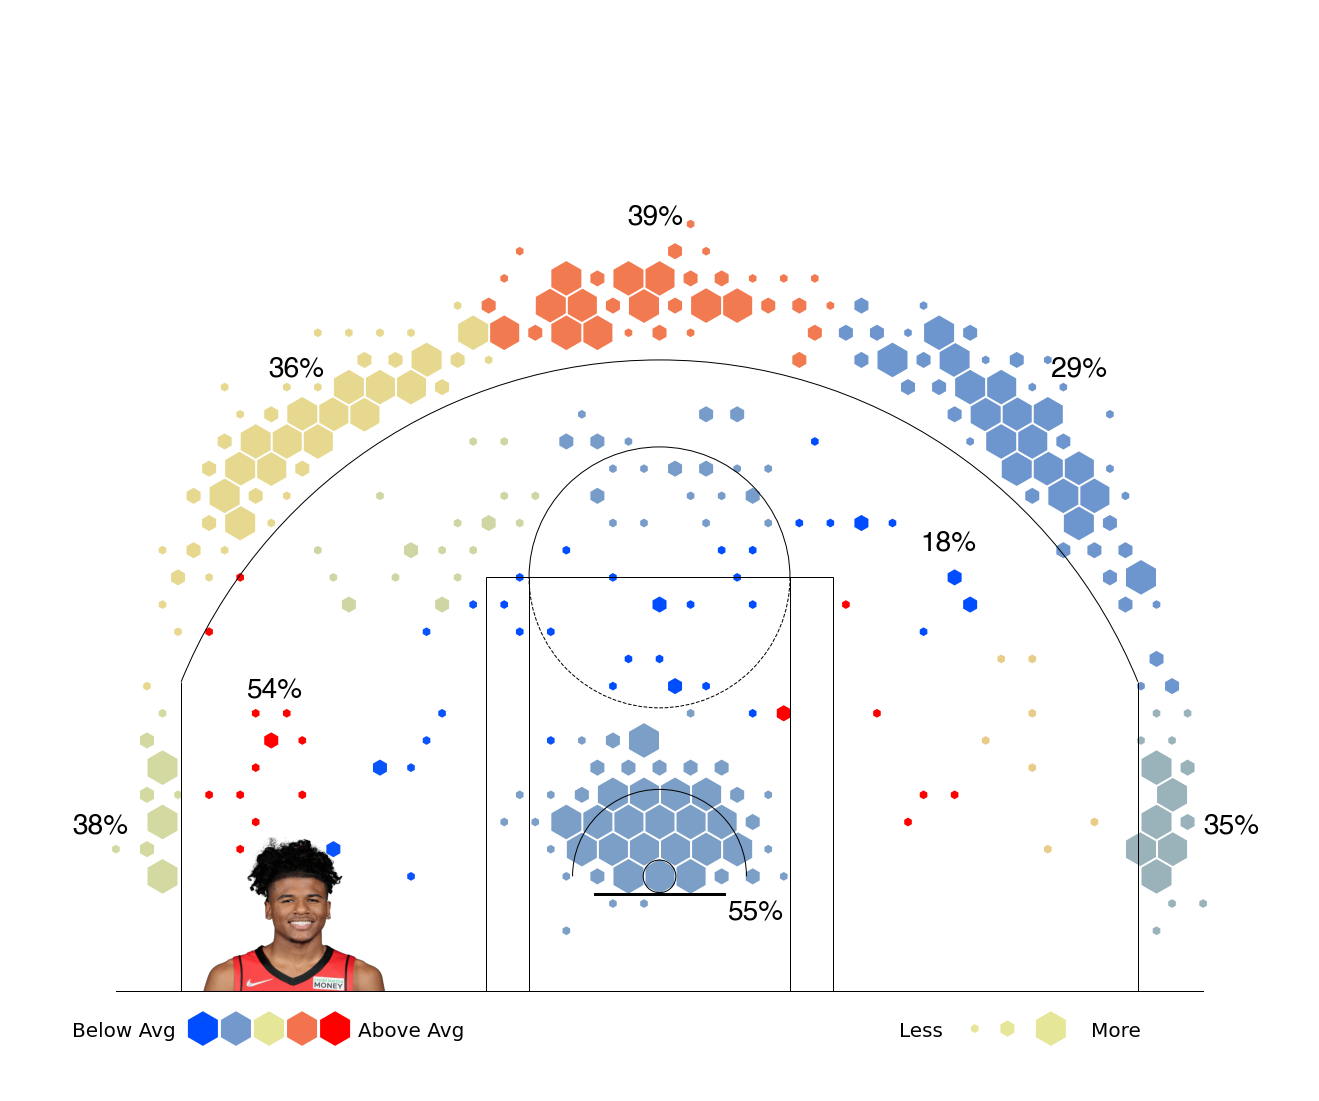

In [98]:
grantland_shotchart(df_player_shots, df_league_average, player_id)

In [99]:
IFrame(src='https://flo.uri.sh/visualisation/11125767/embed', width=975, height=857)